In [1]:
# Helper libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import style
style.use('dark_background')

In [2]:
from sklearn.decomposition import PCA

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
tf_gpus = [x for x in device_lib.list_local_devices() if x.device_type == 'GPU']


In [4]:
import os
import sys

In [5]:
import boto3
client = boto3.Session(profile_name='personal').client("dynamodb")
from jmpy.dynamodb import DynamoDB
dynamodb = DynamoDB(client=client)

In [6]:
def stock_prices(symbol, interpolate=True):
    query = dict(table='Price', filter='symbol = :sym', values={":sym":symbol})
    df = pd.DataFrame(dynamodb.query(**query))
    df.date = df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    df.set_index('date',inplace=True)
    return df

def interpolate_df(df):
    for col in df:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df_reindexed = df.reindex(
        pd.date_range(
            start=df.index.min(),
            end=df.index.max(),
            freq='1D'
        )
    ) 
    df = df_reindexed.interpolate(method='linear') 
    return df


#### Confirm TensorFlow Config

In [8]:
print(tf.__version__)
print(tf_gpus)

1.12.0
[name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6703746908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11396904204011068215
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [9]:
device_lib.list_local_devices() 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13470330271513671707, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6703746908
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6249539029000975521
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"]

#### Get some data

In [10]:
test_sym = 'MSFT'
test_df = stock_prices(test_sym)

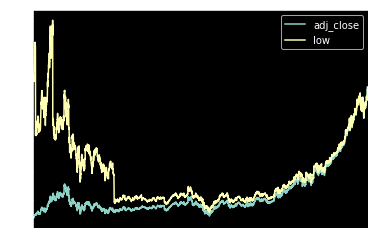

In [11]:
test_df = interpolate_df(test_df)
test_df[['adj_close','low']].plot()

In [12]:
test_df.head()

,adj_close,close,dividend,high,low,open,split,symbol,volume
1998-01-02,10.679600,131.13,0.0,131.50,129.500000,129.63,1.0,NaN,4968500.0
1998-01-03,10.659267,130.88,0.0,132.21,128.956667,130.17,1.0,NaN,6661400.0
1998-01-04,10.638933,130.63,0.0,132.92,128.413333,130.71,1.0,NaN,8354300.0
1998-01-05,10.618600,130.38,0.0,133.63,127.870000,131.25,1.0,NaN,10047200.0
1998-01-06,10.679600,131.13,0.0,133.00,129.250000,129.75,1.0,NaN,8479300.0


#### Percent change

In [242]:
pct_ch = test_df.pct_change()
pct_ch.head(35)

,adj_close,close,dividend,high,low,open,split,symbol,volume
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-03,-0.001904,-0.001907,NaN,0.005399,-0.004196,0.004166,0.0,NaN,0.340727
1998-01-04,-0.001908,-0.001910,NaN,0.005370,-0.004213,0.004148,0.0,NaN,0.254136
1998-01-05,-0.001911,-0.001914,NaN,0.005342,-0.004231,0.004131,0.0,NaN,0.202638
1998-01-06,0.005745,0.005752,NaN,-0.004715,0.010792,-0.011429,0.0,NaN,-0.156053
1998-01-07,-0.011967,-0.011973,NaN,-0.013609,-0.013540,0.001002,0.0,NaN,-0.093486
1998-01-08,0.007250,0.007255,NaN,0.007165,0.000000,-0.009624,0.0,NaN,0.262249
1998-01-09,-0.026815,-0.026820,NaN,-0.004768,-0.012784,0.011117,0.0,NaN,0.127742
1998-01-10,0.006561,0.006562,NaN,-0.003802,-0.003972,-0.013942,0.0,NaN,-0.034808
1998-01-11,0.006519,0.006519,NaN,-0.003817,-0.003988,-0.014139,0.0,NaN,-0.036064


In [280]:
# distribution measures
pct_ch.adj_close.mean(), pct_ch.adj_close.std()**2, pct_ch.adj_close.skew(), pct_ch.adj_close.kurtosis(), pct_ch.adj_close.median()

(0.00042486808522596286,
 0.00022743774093613296,
 0.46809823005510814,
 12.675467590489331,
 0.0001178830073196302)

In [74]:
# how many positive days
sum(pct_ch.adj_close>0)/len(pct_ch)

0.5077279752704791

In [78]:
# metric for yearly return
(1+pct_ch.adj_close.median())**365

1.0439637449283594

In [79]:
(1+pct_ch.adj_close.mean())**365

1.1677092420710897

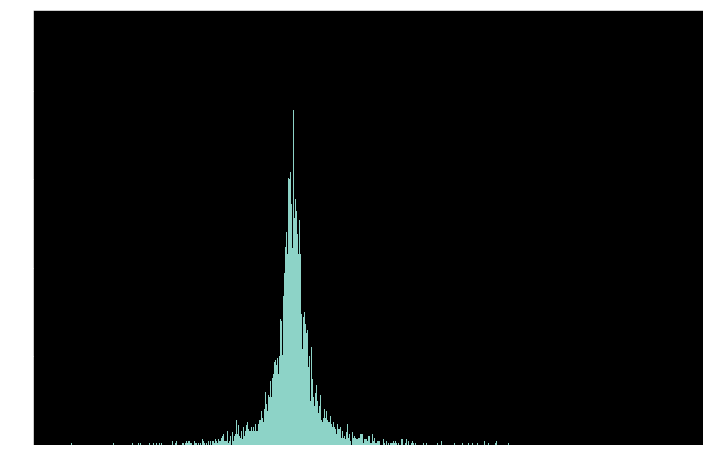

In [80]:
plt.figure(figsize=(12,8))
_ = plt.hist(pct_ch.adj_close, bins=1000)

In [83]:
test_df.pct_change(periods=2).head()

,adj_close,close,dividend,high,low,open,split,symbol,volume
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-04,-0.003808,-0.003813,NaN,0.010798,-0.008391,0.008331,0.0,NaN,0.681453
1998-01-05,-0.003815,-0.003820,NaN,0.010740,-0.008427,0.008297,0.0,NaN,0.508272
1998-01-06,0.003822,0.003828,NaN,0.000602,0.006515,-0.007345,0.0,NaN,0.014962


In [85]:
test_df.pct_change(periods=2).shift(periods=-2).head()

,adj_close,close,dividend,high,low,open,split,symbol,volume
1998-01-02,-0.003808,-0.003813,NaN,0.010798,-0.008391,0.008331,0.0,NaN,0.681453
1998-01-03,-0.003815,-0.003820,NaN,0.010740,-0.008427,0.008297,0.0,NaN,0.508272
1998-01-04,0.003822,0.003828,NaN,0.000602,0.006515,-0.007345,0.0,NaN,0.014962
1998-01-05,-0.006291,-0.006289,NaN,-0.018259,-0.002894,-0.010438,0.0,NaN,-0.234951
1998-01-06,-0.004804,-0.004804,NaN,-0.006541,-0.013540,-0.008632,0.0,NaN,0.144245


In [87]:
# now nans are on the bottom
test_df.pct_change(periods=2).shift(periods=-2).tail()

,adj_close,close,dividend,high,low,open,split,symbol,volume
2019-04-01,0.007982,0.007982,NaN,0.011095,0.008891,0.007650,0.0,NaN,0.003144
2019-04-02,0.001426,0.001426,NaN,0.006277,-0.001181,0.008735,0.0,NaN,0.108616
2019-04-03,-0.000667,-0.000667,NaN,-0.001661,0.001846,-0.003921,0.0,NaN,-0.311572
2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
test_df.adj_close.expanding(min_periods=2)

Expanding [min_periods=2,center=False,axis=0]

#### Normalize

In [32]:
mean_nm = pct_ch.divide(pct_ch.abs().mean(axis=1), axis=0)
mean_nm.head()

,adj_close,close,dividend,high,low,open,split,symbol,volume
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-03,-0.037197,-0.037247,NaN,0.105484,-0.081969,0.081385,0.0,NaN,6.656718
1998-01-04,-0.049149,-0.049215,NaN,0.138365,-0.108556,0.106884,0.0,NaN,6.547831
1998-01-05,-0.060765,-0.060847,NaN,0.169830,-0.134525,0.131350,0.0,NaN,6.442683
1998-01-06,0.206763,0.207043,NaN,-0.169686,0.388437,-0.411341,0.0,NaN,-5.616730


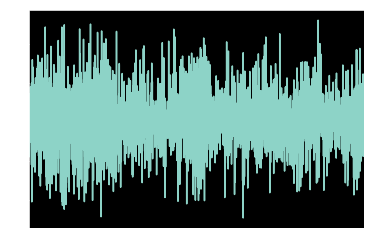

In [33]:
mean_nm.adj_close.plot()

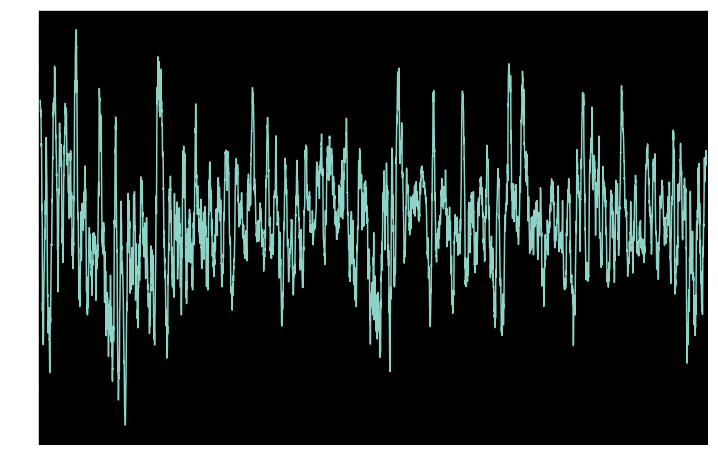

In [60]:
plt.figure(figsize=(12,8))
mean_nm.adj_close.rolling(window=40, win_type='gaussian', center=True).mean(std=20).plot()

In [29]:
pct_ch.divide(pct_ch.abs().max(axis=1), axis=0).head()

,adj_close,close,dividend,high,low,open,split,symbol,volume
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-03,-0.005588,-0.005595,NaN,0.015846,-0.012314,0.012226,0.0,NaN,1.0
1998-01-04,-0.007506,-0.007516,NaN,0.021131,-0.016579,0.016324,0.0,NaN,1.0
1998-01-05,-0.009432,-0.009444,NaN,0.026360,-0.020880,0.020387,0.0,NaN,1.0
1998-01-06,0.036812,0.036862,NaN,-0.030211,0.069157,-0.073235,0.0,NaN,-1.0


In [ ]:
test_df

### Form some X*b = Y

In [262]:
from sklearn.linear_model import LinearRegression

In [237]:
def left_windows(series,size,offset=-1):
    as_strided = np.lib.stride_tricks.as_strided
    data = as_strided(series.values, (len(series) - (size - 1), size), (series.values.strides * 2))
    if offset <= 0:
        nd = len(data)
        data = data[:min([nd-1, nd-1+offset])]
        start_ix = max([0,size-1-offset])
        end_ix = len(data) + start_ix
    else:
        data = data[max([0,offset-size+1]):]
        start_ix = max([size - offset - 1, 0])
        end_ix = -offset
    df = pd.DataFrame(index=series.index[start_ix:end_ix], data=data, columns=list(range(-size+offset+1,offset+1)))
    return df

def right_windows(series,size,offset=1):
    return left_windows(series, size, offset=size-1+offset)

In [243]:
D = left_windows(pct_ch.adj_close,30,offset=-1)

In [252]:
D['y'] = pct_ch.adj_close

In [253]:
D.dropna(inplace=True)

In [254]:
D.head()

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,y
1998-02-02,-0.001904,-0.001908,-0.001911,0.005745,-0.011967,0.007250,-0.026815,0.006561,0.006519,0.006476,...,0.008440,0.008370,0.008300,0.024262,0.026242,-0.005027,0.006336,0.012713,0.012553,0.012398
1998-02-03,-0.001908,-0.001911,0.005745,-0.011967,0.007250,-0.026815,0.006561,0.006519,0.006476,0.020309,...,0.008370,0.008300,0.024262,0.026242,-0.005027,0.006336,0.012713,0.012553,0.012398,0.006461
1998-02-04,-0.001911,0.005745,-0.011967,0.007250,-0.026815,0.006561,0.006519,0.006476,0.020309,-0.007574,...,0.008300,0.024262,0.026242,-0.005027,0.006336,0.012713,0.012553,0.012398,0.006461,0.005963
1998-02-05,0.005745,-0.011967,0.007250,-0.026815,0.006561,0.006519,0.006476,0.020309,-0.007574,0.009008,...,0.024262,0.026242,-0.005027,0.006336,0.012713,0.012553,0.012398,0.006461,0.005963,-0.008738
1998-02-06,-0.011967,0.007250,-0.026815,0.006561,0.006519,0.006476,0.020309,-0.007574,0.009008,0.022216,...,0.026242,-0.005027,0.006336,0.012713,0.012553,0.012398,0.006461,0.005963,-0.008738,0.017307


In [255]:
y = D.pop('y').values

In [257]:
X = D.values

In [274]:
regr = LinearRegression().fit(X,y)

In [277]:
regr.coef_

array([-0.00423418,  0.00976556,  0.01010553, -0.029336  , -0.01432066,
       -0.01629598,  0.00316831, -0.00029793, -0.01709236,  0.01135769,
       -0.005064  ,  0.01966323,  0.00750148,  0.01509445,  0.01040719,
       -0.00169805,  0.01418764, -0.00697005, -0.00346815, -0.00801787,
        0.00666568,  0.00523519,  0.00480196,  0.00955055, -0.03005268,
       -0.01996974, -0.02238005, -0.00554723,  0.0089588 ,  0.0215357 ])

In [281]:
y_hat = regr.predict(X)

In [282]:
def figsize(*args):
    plt.figure(figsize=args)

In [ ]:
figsize(12,8)
plt.plot(y)
plt.plot(y_hat)